In [1]:
%env CUDA_VISIBLE_DEVICES=1
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import flax.linen as nn
jax.devices()

env: CUDA_VISIBLE_DEVICES=1
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


[cuda(id=0)]

# data

(3,) (1024, 1) (1024, 1)


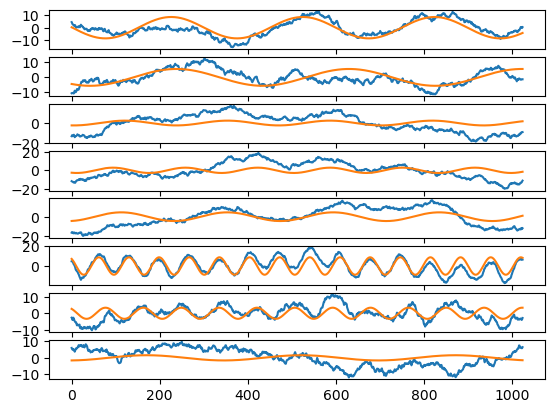

In [2]:
from datasets import SingleSinusoidDataset

noise_psd = lambda f: jnp.where(f==0, 0.0, 1/f)
dataset = SingleSinusoidDataset(noise_psd=noise_psd, noise_scale=0.1)
batch = dataset.get_batch(jr.key(0), 8)
for i, (params, clean, noisy) in enumerate(zip(*batch)):
    plt.subplot(8, 1, i+1)
    plt.plot(noisy)
    plt.plot(clean)
print(params.shape, clean.shape, noisy.shape)

# model

In [3]:
from models import TimeEmbed, ParamEmbed, FCBlock
from models import Patchify, PosEmbed, DiTBlock
from flow_matching import CLIPCNF, Trainer


class SinCNF(CLIPCNF):
    dim: int
    heads: int 
    depth: int 

    @nn.compact
    def __call__(self, t, x, d, x1=None):
        c = TimeEmbed(self.dim)(t) + ParamEmbed(self.dim)(x)
        d = Patchify(self.dim, patch_size=16)(d)
        d = d + PosEmbed(self.dim, max_period=1000)(d)

        for _ in range(self.depth):
            d = DiTBlock(self.heads)(d, c)
            
        d = d[..., -1, :]
        flow = nn.Dense(x.shape[-1])(FCBlock()(d))

        if x1 is not None:
            d_emb = ParamEmbed(self.dim)(d)
            x1_emb = ParamEmbed(self.dim)(x1)
            log_temp = self.param("temp", nn.initializers.zeros, ())
            return flow, x1_emb, d_emb, jnp.exp(log_temp)
        return flow

    def target_flow(self, x0, x1):
        target_flow = x1 - x0
        d_phi = target_flow[..., -1]
        d_phi = jnp.where(d_phi < -jnp.pi, d_phi + 2 * jnp.pi, d_phi)
        d_phi = jnp.where(d_phi > jnp.pi, d_phi - 2 * jnp.pi, d_phi)
        target_flow = target_flow.at[..., -1].set(d_phi)
        return target_flow

# train

In [4]:
def to_flow_space(params):
    amp, omg, phi = jnp.split(params, 3, axis=-1)
    flow_params = [jnp.log10(amp), jnp.log10(omg), phi]
    return jnp.concatenate(flow_params, axis=-1)


def from_flow_space(flow_params):
    log_amp, log_omg, phi = jnp.split(flow_params, 3, axis=-1)
    phi = jnp.where(phi > jnp.pi, phi - 2 * jnp.pi, phi)
    phi = jnp.where(phi < -jnp.pi, phi + 2 * jnp.pi, phi)
    params = [10**log_amp, 10**log_omg, phi]
    return jnp.concatenate(params, axis=-1)


def flow_matching_batch(key, batch_size):
    key_t, key_x0, key_x1 = jr.split(key, 3)
    # t = jax.nn.sigmoid(jr.normal(key_t, (batch_size,)))
    t = jr.uniform(key_t, (batch_size,))

    params_x0, clean_x0, data_x0 = dataset.get_batch(key_x0, batch_size)
    params_x1, clean_x1, data_x1 = dataset.get_batch(key_x1, batch_size)

    # flow in easier space
    cond = data_x1
    x0 = to_flow_space(params_x0)
    x1 = to_flow_space(params_x1)
    return t, x0, x1, cond

In [ ]:
model = SinCNF(depth=4, dim=64, heads=8)
trainer = Trainer(
    get_batch_fn=flow_matching_batch,
    optimizer=optax.adam(1e-4),
    epochs=1000,
    epoch_steps=64,
    batch_size=1024,
    tabulate=True,
)
params, opt_state, losses = trainer.fit(model)


                                 SinCNF Summary                                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path         ┃ module        ┃ inputs        ┃ outputs       ┃ params        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│              │ SinCNF (loss) │ - key<fry>[]  │ float32[]     │ temp:         │
│              │               │ - -           │               │ float32[]     │
│              │               │ float32[1024] │               │               │
│              │               │   -           │               │ 1 (4 B)       │
│              │               │ float32[1024… │               │               │
│              │               │   -           │               │               │
│              │               │ float32[1024… │               │               │
│              │               │   -           │               │               │
│              │           

 44%|████▍     | 445/1000 [34:55<43:11,  4.67s/it, loss=0.22622935]  

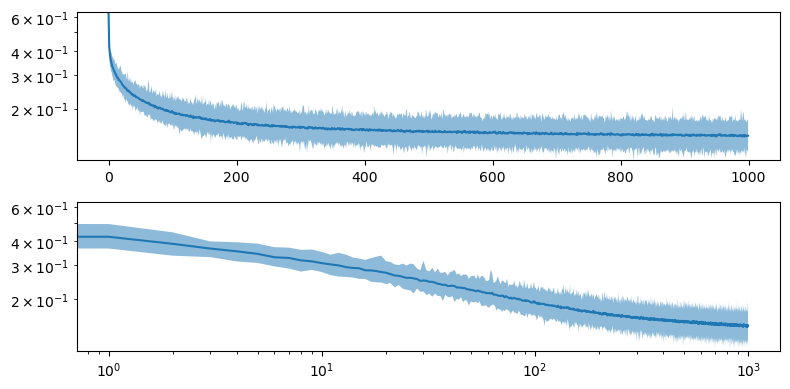

In [5]:
def plot(losses, loglog=False):
    mean = losses.mean(axis=-1)
    min, max = losses.min(axis=-1), losses.max(axis=-1)
    (plt.loglog if loglog else plt.semilogy)(losses.mean(axis=-1))
    plt.fill_between(range(losses.shape[0]), min, max, alpha=0.5)
    plt.ylim(losses.min(), mean.max())


plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plot(losses, loglog=False)
plt.subplot(2, 1, 2)
plot(losses, loglog=True)
plt.tight_layout()

SAMPLING USING CNF
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:02<00:00, 436.26it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:01<00:00, 437.28it/s]


SAMPLING USING CNF
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:02<00:00, 369.40it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:01<00:00, 373.31it/s]


SAMPLING USING CNF
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:02<00:00, 464.43it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:01<00:00, 441.51it/s]


SAMPLING USING CNF
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:02<00:00, 460.41it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:01<00:00, 443.09it/s]


SAMPLING USING CNF
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
(8192, 32, 64)
(8192, 16, 64)
(8192, 8, 64)
(8192, 4, 64)
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:02<00:00, 449.91it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:01<00:00, 448.03it/s]


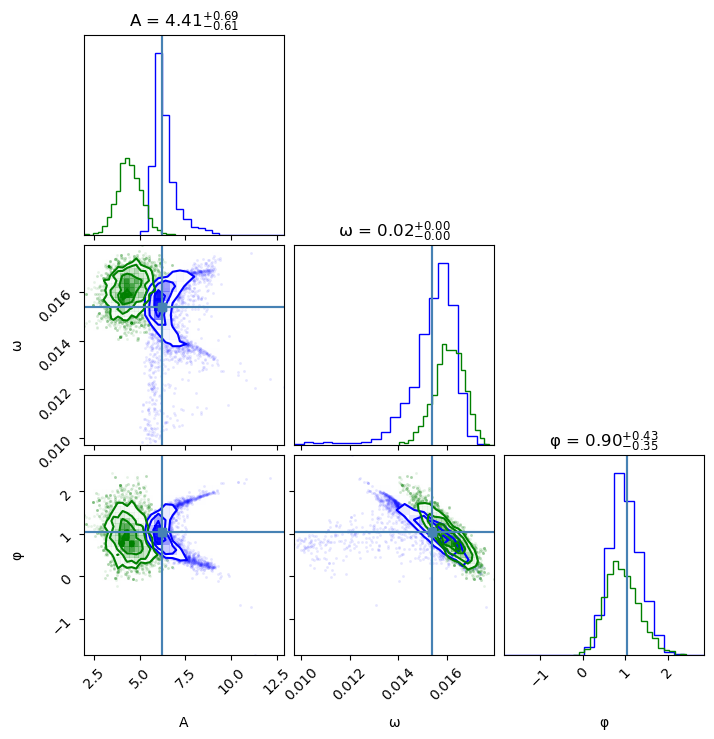

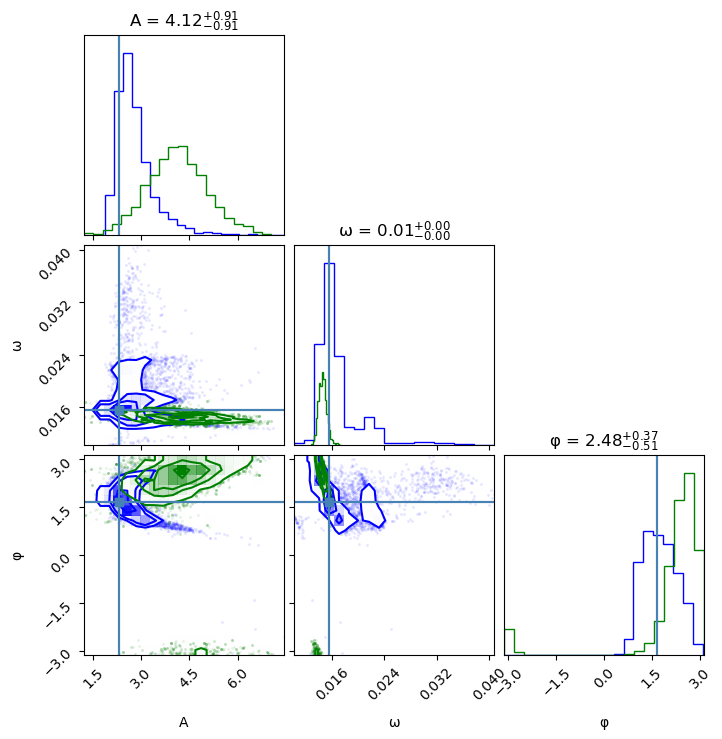

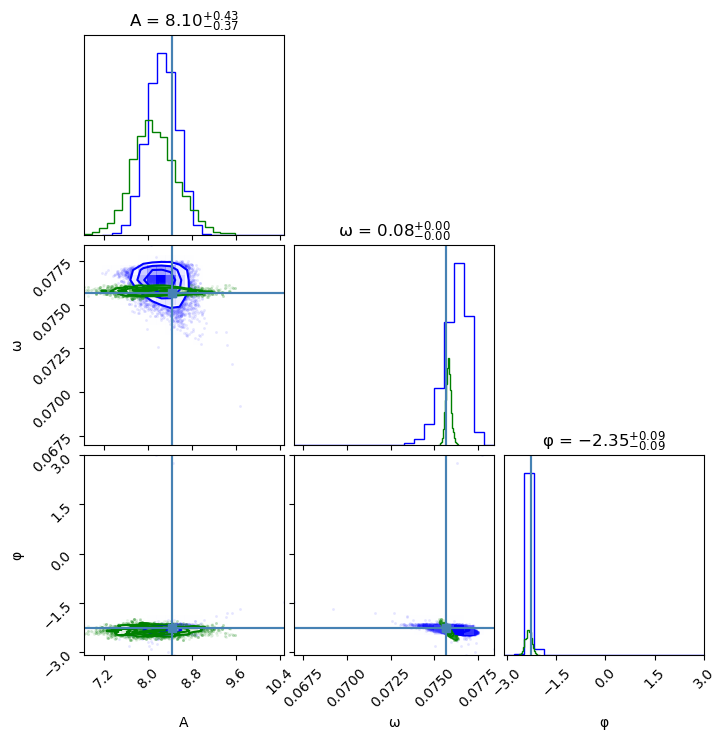

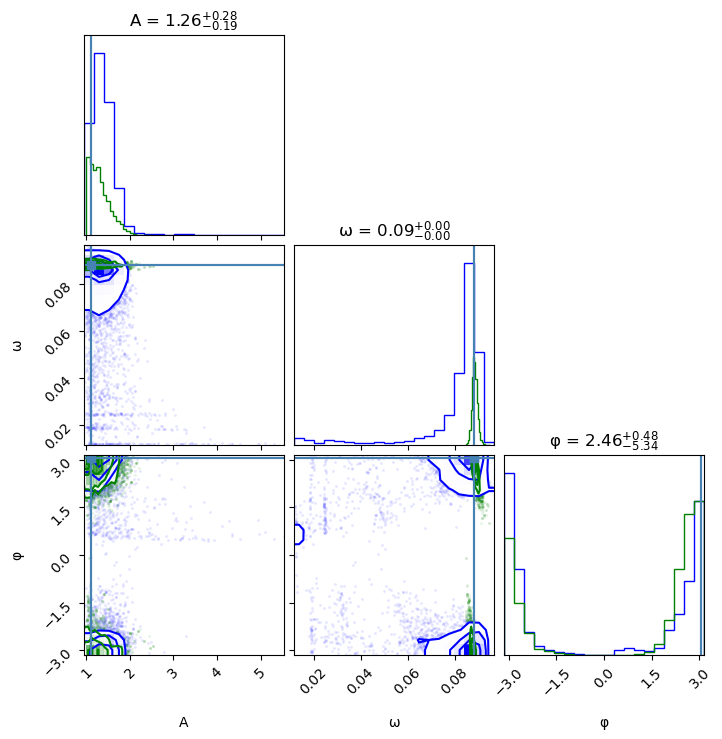

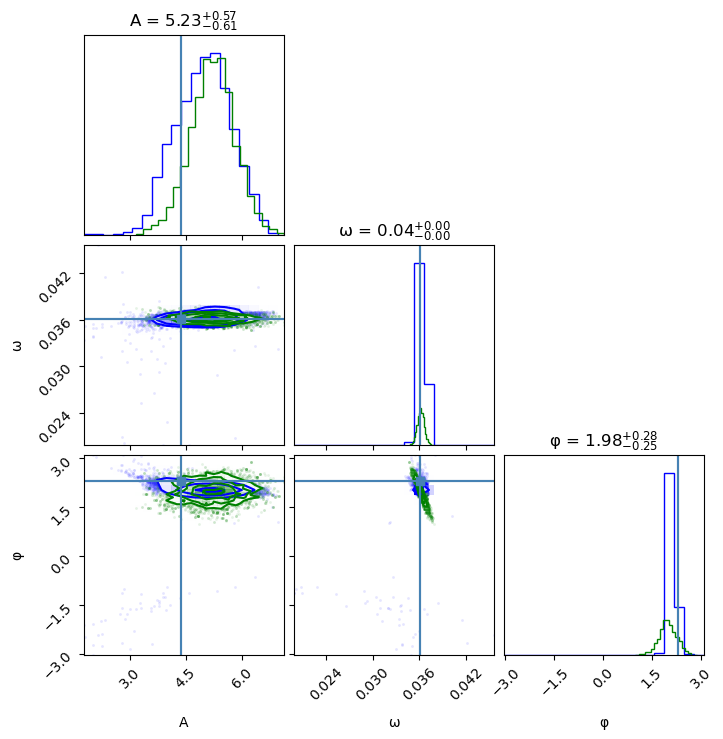

In [6]:
import corner
from mcmc import EmceeSampler

samples = 8 * 1024
for k in range(5):
    t, x0, x1, d = trainer.get_batch_fn(jr.key(k), samples)
    true_params, datastream = np.array(from_flow_space(x1[0])), d[0]

    # sample from prior
    x1_prior = np.array(x0)

    # sample using CNF
    print("SAMPLING USING CNF")
    xt = model.apply(params, x0, datastream, method="push")
    x1_cnf = np.array(from_flow_space(xt[-1]))

    # sample using MCMC
    print("SAMPLING USING MCMC")
    log_post = lambda p: dataset.log_likelihood(p, datastream) + dataset.log_prior(p)
    x1_mcmc = EmceeSampler(burn=1000, walkers=16, steps=samples // 16).run(
        log_prob=jax.jit(log_post), x0=true_params
    )
    x1_mcmc = np.array(from_flow_space(to_flow_space(x1_mcmc)))

    # plot corner
    corner_kwargs = dict(labels=["A", "ω", "φ"], show_titles=True, truths=true_params)
    fig = None  # corner.corner(x1_prior, color="black", **corner_kwargs)
    fig = corner.corner(x1_cnf, color="blue", fig=fig, **corner_kwargs)
    fig = corner.corner(x1_mcmc, color="green", fig=fig, **corner_kwargs)